In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
# from weighted_levenshtein import lev, osa, dam_lev


from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import (streaming_classifier,
                                   three_pronged_smoothing_classifier,
                                   two_pronged_smoothing_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   catch22_knn_classifier)



In [54]:
waves, labels, samprate = load_training_data(path = "Datasets/",
                                             scale_factor= 1,
                                             blacklist = ["data0"],
                                             whitelist = ["data"])

samprate = 10_000


time_buffers = {"data3":(-0.1, 1.3),
                "data2":(-0.2, 1.4),
                "data0":(-0.1, 1.3),
                "data1":(-0.3, 1.4),
                "data5":(-0.4, 1.3),
                "data4":(-0.2, 1.3)}



dict_keys(['data3', 'data2', 'data1', 'data5', 'data4']) dict_keys(['data1', 'data3', 'data2', 'data5', 'data4'])


/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Classifier/load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


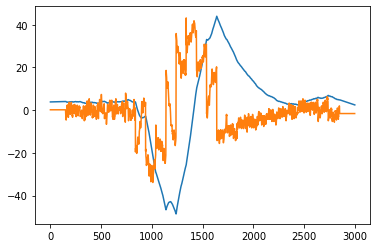

In [99]:
from scipy import signal


def smooth(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)
    
    return(filtered_arr)

    
# plt.plot(waves["data1"][100000:130000]) 


filt = smooth(waves["data1"][100000:130000], 10_000)

plt.plot(filt)
    

plt.plot( np.diff(filt)*100)


In [57]:


window_size = 0.45


def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)


Buffer size 0.05


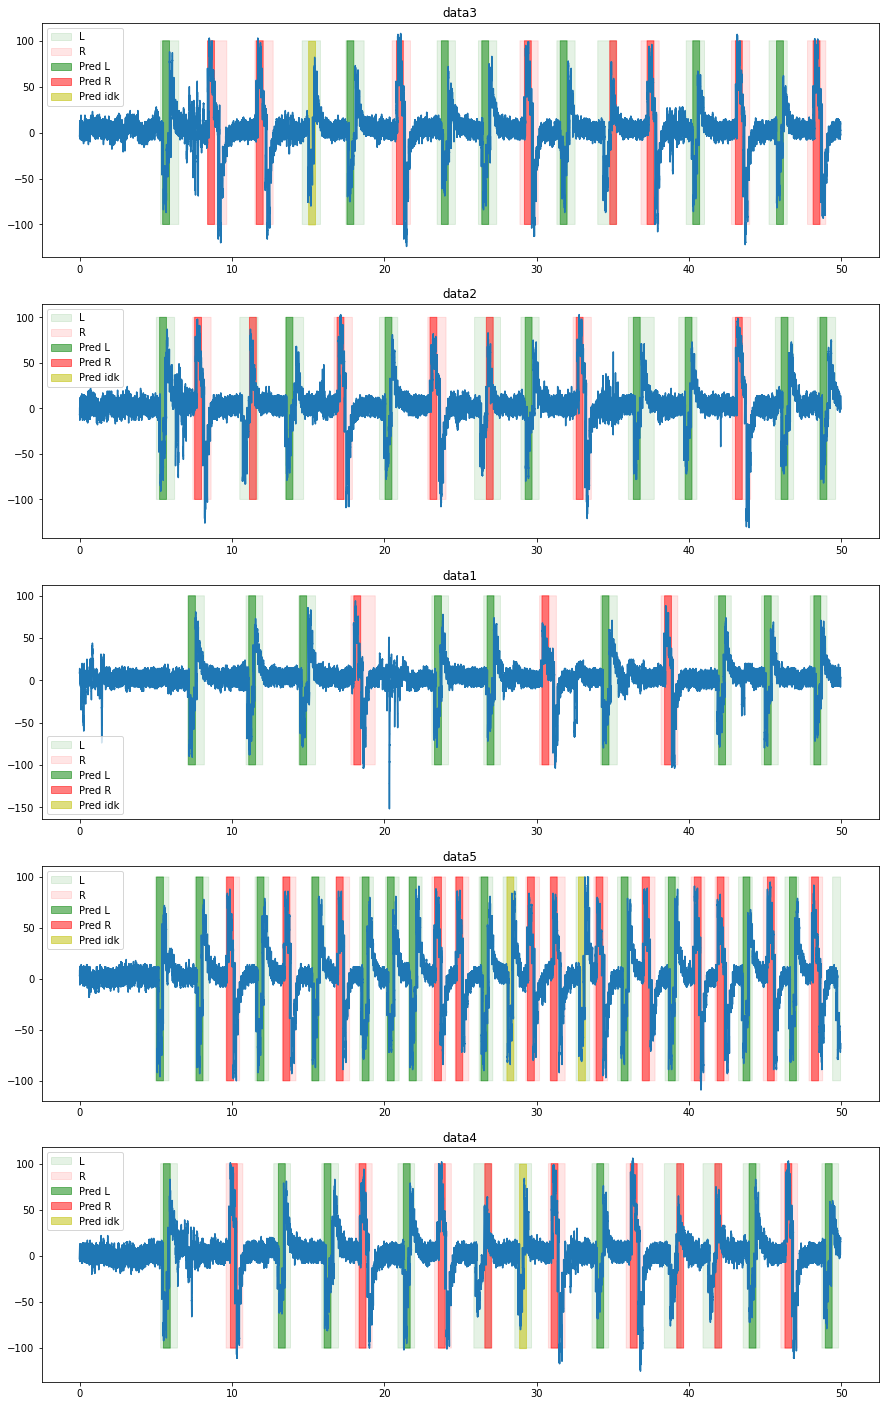

In [109]:
# Centre detection window

hyp_event_smart_threshold_window = 5
hyp_event_smart_threshold_factor = 0.16

print("Buffer size", range_opt_window/9)




fig, ax = plt.subplots(len(waves), 1)

fig.set_size_inches(15, len(waves)*5)


for i, key in enumerate(waves):
    
    
    predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key],
                samprate,
                classifier = zeroes_classifier,
                window_size = window_size, # time plotted in window [s]
                N_loops_over_window = 9, # implicitly defines buffer to be 1/x of the window
                total_time = None,  # max time
                hyp_detection_buffer_end = 0.0001, # seconds - how much time to shave off either end of the window in order to define the middle portion
                hyp_detection_buffer_start = 0,
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, 
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, 
                hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*window_size, # Function that calculates the calibration statistic
                hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
                hyp_event_history = 30,
    #             hyp_timeout = 20,
                hyp_consecutive_triggers = 2,
                hyp_consecutive_reset = 10,
                plot = False,
                store_events = True, 
                verbose=False,
                live = False,
    #             dumb_threshold = True,
                flip_threshold = True
    #             timeout = True
        )




    plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
                         title=key, before_buffer = time_buffers[key][0], after_buffer = time_buffers[key][1], actual_alpha=0.1,
                         wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)




In [29]:
np.linspace(0.01, 1, 100)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [43]:


st_window = 5 # Seconds



st_list = []
f_score_list = []

for st_scale in np.linspace(0.01, 1, 100):

    fps = 0
    fns = 0
    tps = 0


    i=0
    for key in waves.keys():

        predictions, predictions_timestamps, predictions_storage = streaming_classifier(
            waves[key],
            samprate,
            classifier = zeroes_classifier,
            window_size = range_opt_window, # time plotted in window [s]
            N_loops_over_window = 9, # implicitly defines buffer to be 1/x of the window
            total_time = None,  # max time
            hyp_detection_buffer_end = 0.0001, # seconds - how much time to shave off either end of the window in order to define the middle portion
            hyp_detection_buffer_start = 0,
            hyp_event_smart_threshold_window = st_window, 
            hyp_event_smart_threshold_factor = st_scale, 
            hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*range_opt_window, # Function that calculates the calibration statistic
            hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
            hyp_event_history = 30,
#             hyp_timeout = 20,
            hyp_consecutive_triggers = 2,
            hyp_consecutive_reset = 10,
            plot = False,
            store_events = True, 
            verbose=False,
            live = False,
#             dumb_threshold = True,
            flip_threshold = True
#             timeout = True
        )
        
        before_buffer = time_buffers[key][0]
        after_buffer = time_buffers[key][1]

        actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
        actual_leftovers = deepcopy(actual_times)
        pred_leftovers = deepcopy(predictions_timestamps)
        
        tps += len(actual_times)


        for act_times in actual_times:
            if act_times[1] < st_window:
                actual_leftovers.remove(act_times)
                continue
            for pred_times in predictions_timestamps:
                if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                    actual_leftovers.remove(act_times)
                    pred_leftovers.remove(pred_times)
                    
                    
        
        file_fscore = (len(actual_times) - len(actual_leftovers))/((len(actual_times) - len(actual_leftovers))+0.5*(len(actual_leftovers)+len(pred_leftovers))) 
        print(key, file_fscore)

        tps -= len(actual_leftovers)
    
        fns += len(actual_leftovers)
        fps += len(pred_leftovers)


        i+=1
        
        
    fscore = tps/(tps+0.5*(fns+fps))
        
    print(st_scale, fscore)
    st_list.append(st_scale)
    f_score_list.append(fscore)



    
    

data3 0.47619047619047616
data2 0.38095238095238093
data1 0.47058823529411764
data5 0.5263157894736842
data4 0.3
0.01 0.4444444444444444
data3 0.6666666666666666
data2 0.5833333333333334
data1 0.7
data5 0.7555555555555555
data4 0.45454545454545453
0.02 0.6518518518518519
data3 0.7692307692307693
data2 0.7407407407407407
data1 0.96
data5 0.9230769230769231
data4 0.64
0.03 0.8258064516129032
data3 0.8571428571428571
data2 0.7407407407407407
data1 0.96
data5 0.9433962264150944
data4 0.64
0.04 0.8481012658227848
data3 0.896551724137931
data2 0.8275862068965517
data1 0.96
data5 0.9433962264150944
data4 0.7407407407407407
0.05 0.8834355828220859
data3 0.896551724137931
data2 0.8666666666666667
data1 0.96
data5 0.9818181818181818
data4 0.7407407407407407
0.060000000000000005 0.9036144578313253
data3 0.896551724137931
data2 0.9032258064516129
data1 0.96
data5 0.9818181818181818
data4 0.8275862068965517
0.06999999999999999 0.9230769230769231
data3 0.967741935483871
data2 0.9032258064516129
data

data1 0.8
data5 0.8085106382978723
data4 1.0
0.68 0.8735632183908046
data3 0.875
data2 0.9032258064516129
data1 0.8
data5 0.8085106382978723
data4 1.0
0.6900000000000001 0.8735632183908046
data3 0.875
data2 0.9032258064516129
data1 0.8
data5 0.782608695652174
data4 1.0
0.7000000000000001 0.8670520231213873
data3 0.875
data2 0.875
data1 0.8
data5 0.782608695652174
data4 1.0
0.7100000000000001 0.8620689655172413
data3 0.9032258064516129
data2 0.875
data1 0.8
data5 0.7272727272727273
data4 1.0
0.72 0.8538011695906432
data3 0.9032258064516129
data2 0.875
data1 0.8
data5 0.7272727272727273
data4 1.0
0.73 0.8538011695906432
data3 0.9032258064516129
data2 0.875
data1 0.8
data5 0.6976744186046512
data4 1.0
0.74 0.8470588235294118
data3 0.9032258064516129
data2 0.8484848484848485
data1 0.8
data5 0.6976744186046512
data4 1.0
0.75 0.8421052631578947
data3 0.9032258064516129
data2 0.8484848484848485
data1 0.8
data5 0.6666666666666666
data4 1.0
0.76 0.8352941176470589
data3 0.9032258064516129
data2

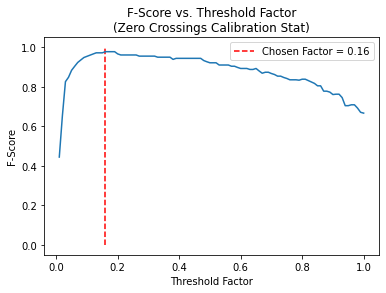

In [44]:
plt.plot(st_list, f_score_list)
plt.title("F-Score vs. Threshold Factor\n(Zero Crossings Calibration Stat)")
plt.vlines(st_list[np.argmax(f_score_list)], 0, 1, "r", "--", label=f"Chosen Factor = {st_list[np.argmax(f_score_list)]}")
plt.xlabel("Threshold Factor")
plt.ylabel("F-Score")
plt.legend()

In [45]:
st_list[np.argmax(f_score_list)]

0.16

In [110]:
np.max(f_score_list)

0.9775280898876404